<a href="https://colab.research.google.com/github/Preeti0357/projects/blob/main/cocacolastock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy matplotlib seaborn yfinance scikit-learn finta backtesting streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from finta import TA
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import streamlit as st
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

/usr/local/lib/python3.11/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [ ]:
import zipfile
import io
import pandas as pd

zip_file_path = '/content/archive (1).zip'
csv_file_name = 'Coca-Cola_stock_history.csv'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zf:
        with zf.open(csv_file_name) as f:
            data = pd.read_csv(io.BytesIO(f.read()), parse_dates=['Date'])

    # Display data structure
    print(data.info())
    print(data.head())

except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found. Please ensure the zip file is uploaded to the correct location.")
except KeyError:
    print(f"Error: The file '{csv_file_name}' was not found within the zip archive. Please check the file name inside the zip.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15311 entries, 0 to 15310
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          15311 non-null  object 
 1   Open          15311 non-null  float64
 2   High          15311 non-null  float64
 3   Low           15311 non-null  float64
 4   Close         15311 non-null  float64
 5   Volume        15311 non-null  int64  
 6   Dividends     15311 non-null  float64
 7   Stock Splits  15311 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 957.1+ KB
None
         Date      Open      High       Low     Close   Volume  Dividends  \
0  1962-01-02  0.050016  0.051378  0.050016  0.050016   806400        0.0   
1  1962-01-03  0.049273  0.049273  0.048159  0.048902  1574400        0.0   
2  1962-01-04  0.049026  0.049645  0.049026  0.049273   844800        0.0   
3  1962-01-05  0.049273  0.049892  0.048035  0.048159  1420800        0.0   
4  1962-

In [ ]:
print(data.isnull().sum())
data.fillna(method='ffill', inplace=True)
data.fillna({'Dividends': 0, 'Stock Splits': 0}, inplace=True)
print(data.isnull().sum())  # Should show 0
data.drop_duplicates(inplace=True)
print(f"Rows after removing duplicates: {len(data)}")

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Rows after removing duplicates: 15311


In [ ]:
# Add Moving Averages
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()

# Add Daily Returns
data['Daily_Return'] = data['Close'].pct_change()

# Add Volatility
data['Volatility'] = data['Daily_Return'].rolling(window=20).std()

# Drop rows with NaN from rolling calculations
data.dropna(inplace=True)
print(data.head())

          Date      Open      High       Low     Close   Volume  Dividends  \
49  1962-03-13  0.046416  0.046789  0.046416  0.046789  1344000   0.001563   
50  1962-03-14  0.046789  0.046976  0.046603  0.046852  1689600   0.000000   
51  1962-03-15  0.046852  0.046976  0.046603  0.046603   883200   0.000000   
52  1962-03-16  0.046603  0.046789  0.046603  0.046603   768000   0.000000   
53  1962-03-19  0.046603  0.047101  0.046603  0.046852   921600   0.000000   

    Stock Splits     MA_20     MA_50  Daily_Return  Volatility  
49             0  0.045788  0.046525      0.015962    0.013223  
50             0  0.045797  0.046461      0.001334    0.013226  
51             0  0.045836  0.046415     -0.005320    0.012546  
52             0  0.045889  0.046362      0.000000    0.012460  
53             0  0.045953  0.046336      0.005348    0.012491  


               Open          High           Low         Close        Volume  \
count  15262.000000  15262.000000  15262.000000  15262.000000  1.526200e+04   
mean      11.850660     11.944785     11.754847     11.853194  9.164087e+06   
std       15.035006     15.142659     14.924814     15.035590  7.957132e+06   
min        0.037154      0.037279      0.034890      0.037028  7.680000e+04   
25%        0.239461      0.241549      0.237297      0.239432  2.947200e+06   
50%        4.959658      5.012348      4.918166      4.959969  7.732300e+06   
75%       17.425250     17.663839     17.230594     17.456363  1.309292e+07   
max       66.037933     66.235058     64.776308     65.259270  1.241690e+08   

          Dividends  Stock Splits         MA_20         MA_50  Daily_Return  \
count  15262.000000  15262.000000  15262.000000  15262.000000  15262.000000   
mean       0.001683      0.001114     11.818108     11.760960      0.000576   
std        0.021336      0.049226     14.991442    

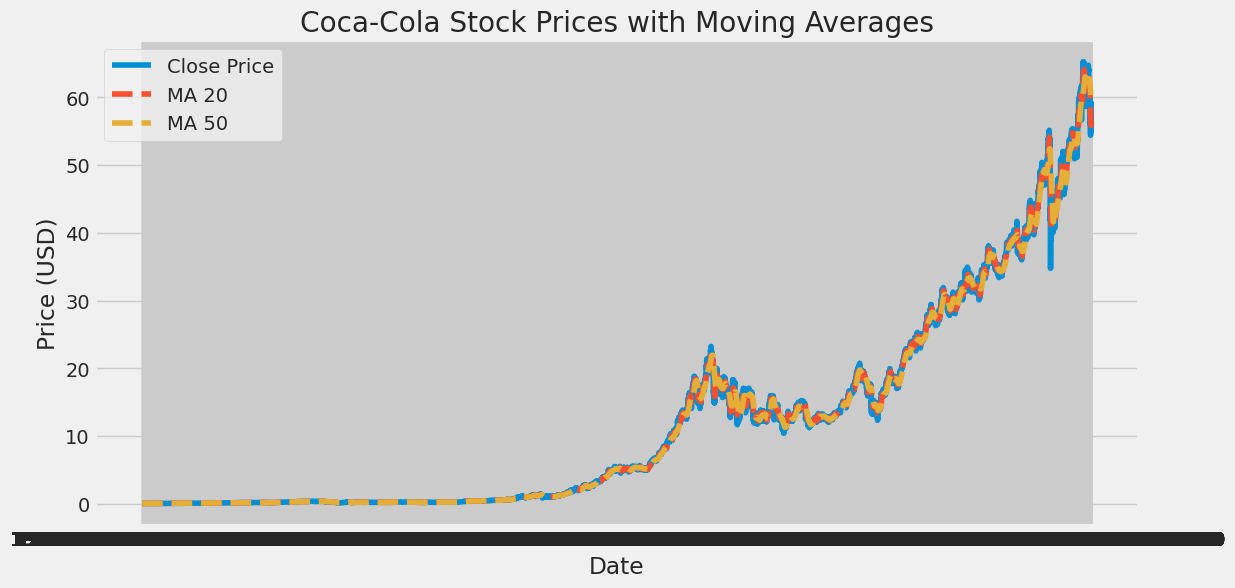

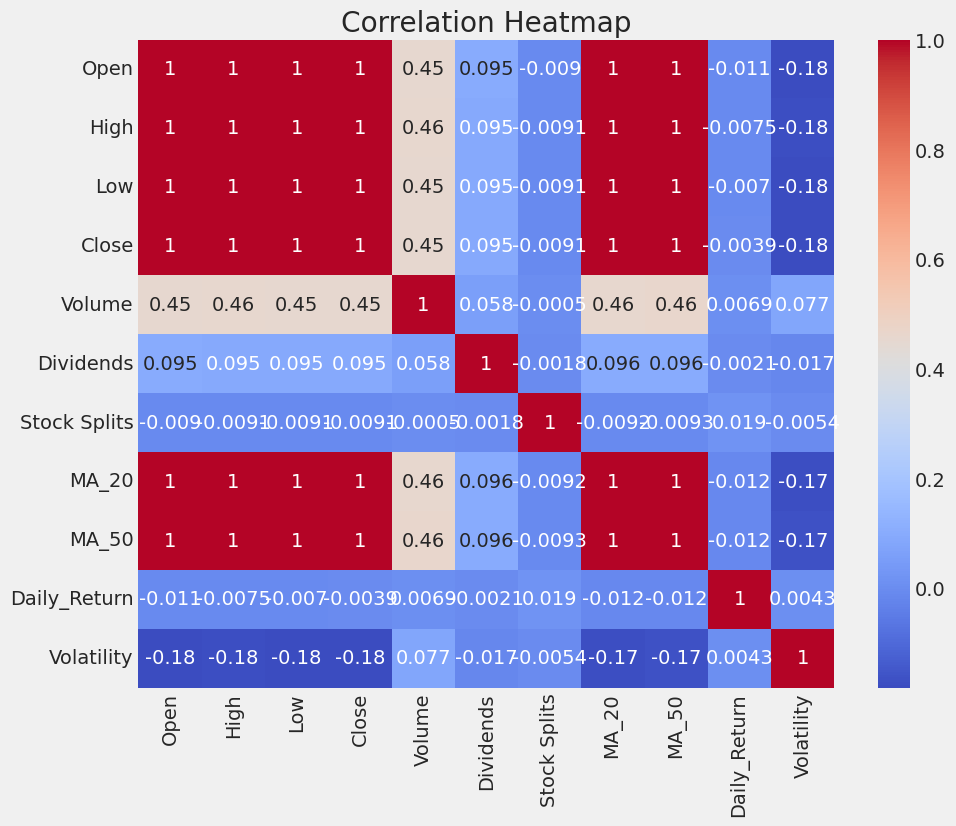

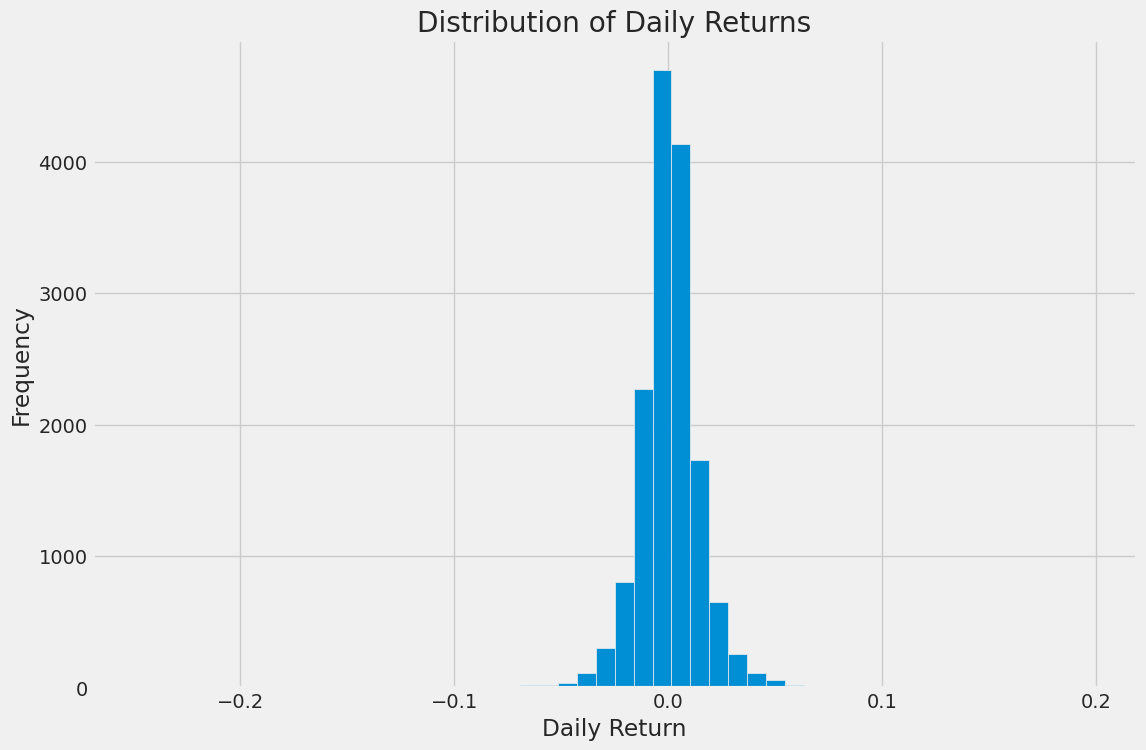

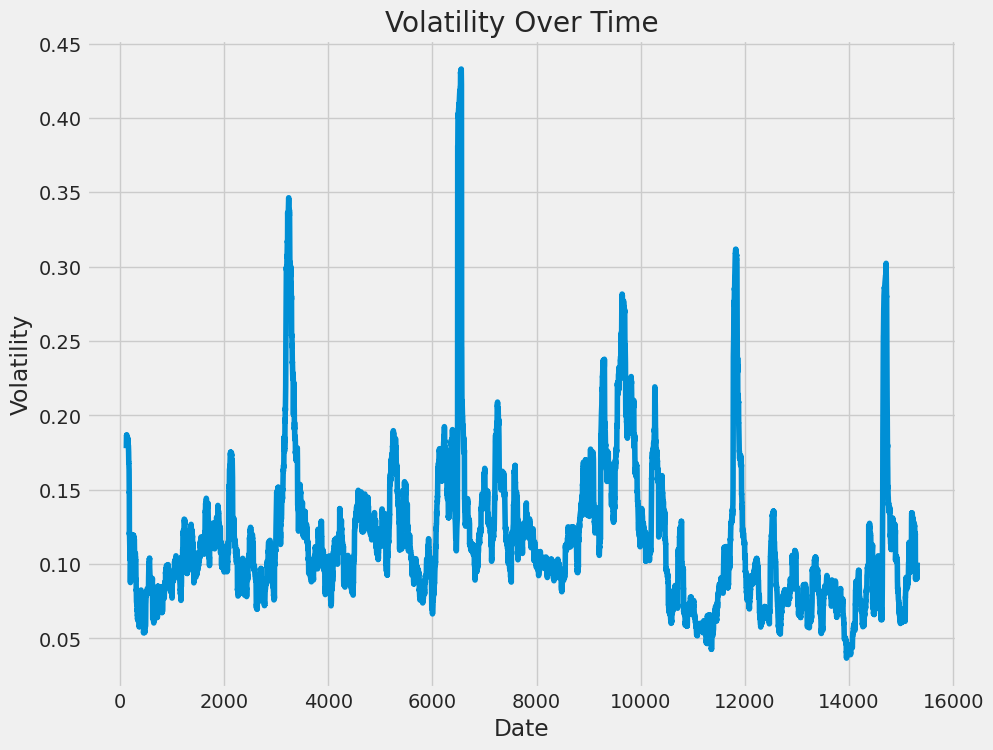

In [ ]:
print(data.describe())
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], data['MA_20'], label='MA 20', linestyle='--')
plt.plot(data['Date'], data['MA_50'], label='MA 50', linestyle='--')
plt.title('Coca-Cola Stock Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('stock_prices.png')
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(data.drop('Date', axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

data['SMA5'] = data['Close'].rolling(window=5).mean()
data['SMA20'] = data['Close'].rolling(window=20).mean()
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

fig = go.Figure(data=[
    go.Ohlc(x=data['Date'], open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='OHLC'),
    go.Scatter(x=data['Date'], y=data['SMA5'], line=dict(color='orange', width=1), name='SMA5'),
    go.Scatter(x=data['Date'], y=data['SMA20'], line=dict(color='green', width=1), name='SMA20'),
    go.Scatter(x=data['Date'], y=data['SMA50'], line=dict(color='blue', width=1), name='SMA50'),
    go.Scatter(x=data['Date'], y=data['SMA200'], line=dict(color='violet', width=1), name='SMA200')
])
fig.update_layout(title='Coca-Cola Stock OHLC with SMAs', xaxis_title='Date', yaxis_title='Price (USD)')
fig.write_html('ohlc_chart.html')
fig.show()

plt.figure(figsize=(12, 8))
data['Daily_Return'].hist(bins=50)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.savefig('daily_returns.png')
plt.show()

plt.figure(figsize=(10, 8))
(data['Daily_Return'].rolling(window=75).std() * np.sqrt(75)).plot()
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.savefig('volatility.png')
plt.show()

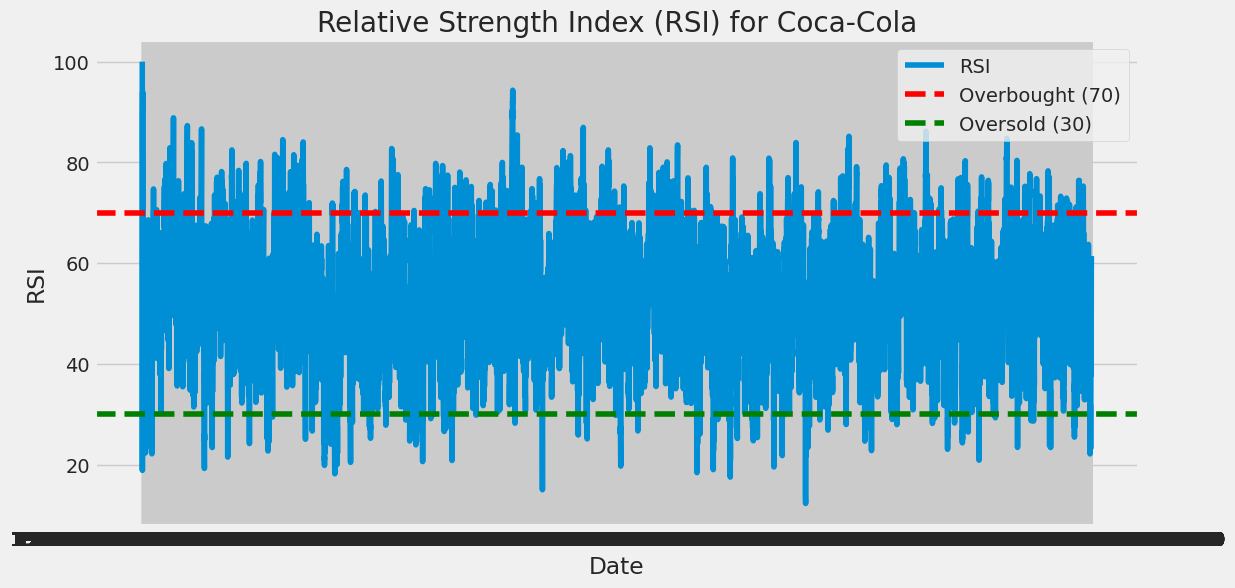

In [ ]:
# Ensure Date is not the index for Finta compatibility
data = data.reset_index(drop=True)

# Calculate selected technical indicators
data['SMA_42'] = TA.SMA(data, 42)
data['RSI'] = TA.RSI(data)
data['MACD'] = TA.MACD(data)['MACD']
bbands = TA.BBANDS(data)
data['BB_upper'] = bbands['BB_UPPER']
data['BB_middle'] = bbands['BB_MIDDLE']
data['BB_lower'] = bbands['BB_LOWER']
data['ATR'] = TA.ATR(data)

# Plot RSI as an example
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['RSI'], label='RSI')
plt.title('Relative Strength Index (RSI) for Coca-Cola')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.axhline(70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='g', linestyle='--', label='Oversold (30)')
plt.legend()
plt.savefig('rsi.png')
plt.show()

In [ ]:
features = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'MA_20', 'MA_50', 'Daily_Return', 'Volatility', 'SMA_42', 'RSI', 'MACD', 'BB_upper', 'BB_lower', 'ATR']
target = 'Close'

# Ensure no NaN in features
data = data.dropna(subset=features + [target])

X = data[features]
y = data[target]

# Train-test split (80-20, no shuffle for time-series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

Mean Squared Error: 334.5643
Mean Absolute Error: 14.9040


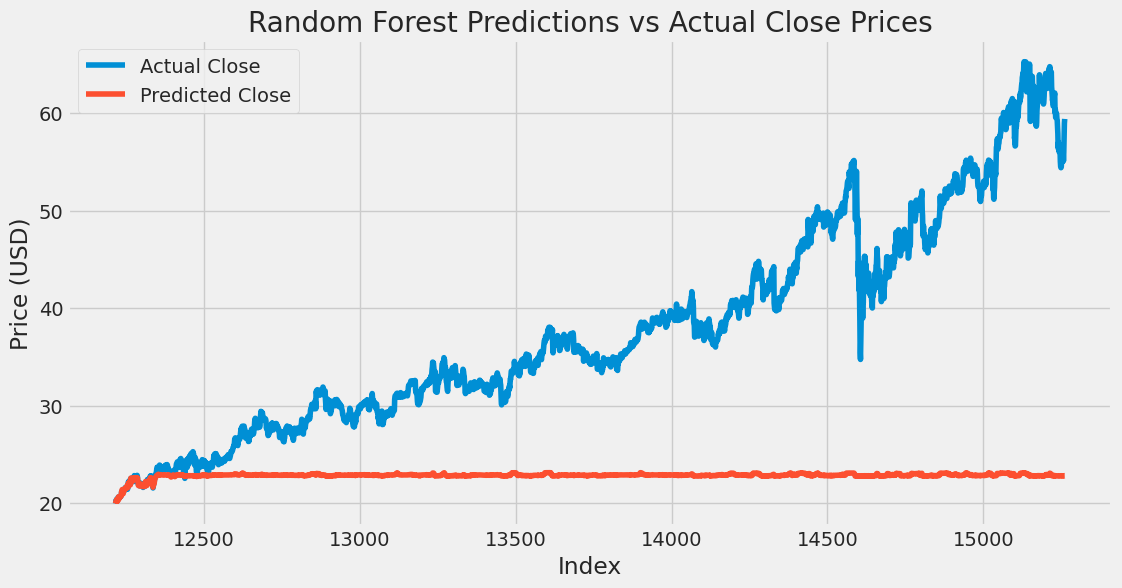

In [ ]:
# Initialize and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close')
plt.plot(y_test.index, y_pred, label='Predicted Close')
plt.title('Random Forest Predictions vs Actual Close Prices')
plt.xlabel('Index')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('predictions.png')
plt.show()

In [ ]:
import zipfile
import io
import pandas as pd
from finta import TA
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

class DemaCross(Strategy):
    def init(self):
        self.ma1 = self.I(TA.DEMA, self.data.Close, 10)
        self.ma2 = self.I(TA.DEMA, self.data.Close, 20)
    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()

# Re-load the data to ensure 'Date' column is present
zip_file_path = '/content/archive (1).zip'
csv_file_name = 'Coca-Cola_stock_history.csv'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zf:
        with zf.open(csv_file_name) as f:
            data = pd.read_csv(io.BytesIO(f.read()), parse_dates=['Date'])

    # Ensure data has a DatetimeIndex for backtesting and required columns
    data = data.set_index('Date')
    data_for_backtest = data[['Open', 'High', 'Low', 'Close', 'Volume']]

    # Run backtest
    bt = Backtest(data_for_backtest, DemaCross, cash=100000, commission=0.015, exclusive_orders=True)
    stats = bt.run()
    print(stats)
    bt.plot(filename='backtest.html')

except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found. Please ensure the zip file is uploaded to the correct location.")
except KeyError:
    print(f"Error: The file '{csv_file_name}' was not found within the zip archive. Please check the file name inside the zip.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

An unexpected error occurred: Indicator "DEMA(C,10)" error. See traceback above.


In [ ]:
# Define the ticker symbol
ticker = 'KO' # Coca-Cola

# Fetch live data (1-minute interval for the last day)
live_data = yf.download(ticker, period='1d', interval='1m')

# Flatten MultiIndex columns if they exist
if isinstance(live_data.columns, pd.MultiIndex):
    live_data.columns = ['_'.join(col).strip() for col in live_data.columns.values]

# Ensure column names are in lowercase for Finta compatibility (as it seems to expect lowercase)
live_data.columns = live_data.columns.str.lower()

# Rename columns to match expected simple names
# Adjusted keys to match actual column names after lowercasing
live_data.rename(columns={'open_ko': 'open', 'high_ko': 'high', 'low_ko': 'low', 'close_ko': 'close', 'volume_ko': 'volume'}, inplace=True)

# Drop columns that are not needed for Finta or model
columns_to_drop = [col for col in live_data.columns if col not in ['open', 'high', 'low', 'close', 'volume']]
live_data.drop(columns=columns_to_drop, inplace=True)

# Add features using lowercase column names for Finta
live_data['ma_20'] = live_data['close'].rolling(window=20).mean()
live_data['ma_50'] = live_data['close'].rolling(window=50).mean()
live_data['daily_return'] = live_data['close'].pct_change()
live_data['volatility'] = live_data['daily_return'].rolling(window=20).std()
live_data['sma_42'] = TA.SMA(live_data, 42)
live_data['rsi'] = TA.RSI(live_data)
live_data['macd'] = TA.MACD(live_data)['MACD']
bbands = TA.BBANDS(live_data)
live_data['bb_upper'] = bbands['BB_UPPER']
live_data['bb_middle'] = bbands['BB_MIDDLE']
live_data['bb_lower'] = bbands['BB_LOWER']
live_data['atr'] = TA.ATR(live_data)

# Handle missing values
live_data.fillna(method='ffill', inplace=True)
live_data.fillna(0, inplace=True)

# Define features used during training (using the original capitalization)
features_trained = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'MA_20', 'MA_50', 'Daily_Return', 'Volatility', 'SMA_42', 'RSI', 'MACD', 'BB_upper', 'BB_lower', 'ATR']

# Prepare latest features for prediction, ensuring correct column names and order
if not live_data.empty:
    # Select available features from live_data (using lowercase names)
    available_live_features_lower = [f.lower() for f in features_trained if f.lower() in live_data.columns]
    latest_features_lower = live_data[available_live_features_lower].iloc[-1:]

    # Rename columns to match the capitalization used during training
    rename_dict = {f.lower(): f for f in features_trained if f.lower() in live_data.columns}
    latest_features_capitalized = latest_features_lower.rename(columns=rename_dict)

    # Add back any missing features that were in the training data but not in live data, filling with 0
    missing_features_trained = [f for f in features_trained if f not in latest_features_capitalized.columns]
    for mf in missing_features_trained:
        latest_features_capitalized[mf] = 0

    # Ensure the order of columns in latest_features_capitalized matches the order of features_trained
    latest_features_final = latest_features_capitalized[features_trained]

    # Predict using the prepared latest data point
    live_prediction = model.predict(latest_features_final)
    print(f"Predicted Closing Price: ${live_prediction[0]:.2f}")
else:
    print("Live data is empty, cannot make a prediction.")

[*********************100%***********************]  1 of 1 completed

Predicted Closing Price: $22.87


In [ ]:
# Save as app.py
st.title('Coca-Cola Stock Price Prediction')

# Ensure data is available and has necessary columns
if data is not None and not data.empty:
    # Recalculate MA_20 and MA_50 if they are not in data
    if 'MA_20' not in data.columns:
        data['MA_20'] = data['Close'].rolling(window=20).mean()
    if 'MA_50' not in data.columns:
        data['MA_50'] = data['Close'].rolling(window=50).mean()

    # Drop rows with NaN values created by rolling calculations if necessary
    data.dropna(subset=['Close', 'MA_20', 'MA_50'], inplace=True)

    # Display stock price chart
    st.line_chart(data[['Close', 'MA_20', 'MA_50']])

    # Display prediction
    # Ensure live_prediction is available
    if 'live_prediction' in locals():
        st.write(f"Predicted Closing Price: ${live_prediction[0]:.2f}")
    else:
        st.write("Live prediction not available.")

    # Display company info (from document)
    st.subheader('Company Information')
    st.write(f"Name: The Coca-Cola Company")
    st.write(f"Sector: Consumer Defensive")
    st.write(f"Industry: Beverages-Non-Alcoholic")
    st.write(f"Market Cap: ${257437417472/1e9:.2f}B")
    st.write(f"Dividend Yield: {0.0281*100:.2f}%")
    st.write(f"Return on Equity: {0.3972*100:.2f}%")
else:
    st.write("Stock data not available for plotting.")

2025-07-13 09:43:31.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-13 09:43:31.874 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-13 09:43:31.875 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-13 09:43:32.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-13 09:43:32.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-13 09:43:32.707 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-13 09:43:32.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-13 09:43:32.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!streamlit run app.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
